# Experiment Summary

This notebook summarizes the training experiments from the logs.


In [1]:
# First chunk - creates a DataFrame with checkboxes
import pandas as pd
from datetime import datetime
import re
import os
import ipywidgets as widgets
from IPython.display import display

def parse_log_file(filename):
    with open(filename, 'r') as f:
        content = f.read()
    
    # Extract timestamp from filename
    timestamp_str = re.search(r'training_log_(\d{8}_\d{6})', filename).group(1)
    timestamp = datetime.strptime(timestamp_str, '%Y%m%d_%H%M%S')
    
    # Extract hyperparameters
    hyperparams = {
        'num_epochs': int(re.search(r'NUM_EPOCHS: (\d+)', content).group(1)),
        'batch_size': int(re.search(r'BATCH_SIZE: (\d+)', content).group(1)),
        'learning_rate': float(re.search(r'LEARNING_RATE: ([\d\.]+)', content).group(1)),
        'num_samples': int(re.search(r'NUM_SAMPLES: (\d+)', content).group(1)),
        'input_dim': int(re.search(r'INPUT_DIM: (\d+)', content).group(1)),
        'output_dim': int(re.search(r'OUTPUT_DIM: (\d+)', content).group(1))
    }
    
    # Extract final metrics
    final_train_loss = float(re.search(r'Final Training Loss: ([\d\.]+)', content).group(1))
    final_val_loss = float(re.search(r'Final Validation Loss: ([\d\.]+)', content).group(1))
    
    return {
        'timestamp': timestamp,
        'filename': filename,
        'hyperparameters': hyperparams,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss
    }

# Get all log files from the directory
log_dir = 'output/logs'
log_files = [f for f in os.listdir(log_dir) if f.startswith('training_log_') and f.endswith('.txt')]

# Parse all log files and collect data
all_experiments = []
for log_file in log_files:
    full_path = os.path.join(log_dir, log_file)
    experiment_data = parse_log_file(full_path)
    all_experiments.append({
        'Time': experiment_data['timestamp'],
        'Filename': log_file,  # Store the filename for later reference
        'Epochs': experiment_data['hyperparameters']['num_epochs'],
        'Batch Size': experiment_data['hyperparameters']['batch_size'],
        'Learning Rate': experiment_data['hyperparameters']['learning_rate'],
        'Num Samples': experiment_data['hyperparameters']['num_samples'],
        'Input Dim': experiment_data['hyperparameters']['input_dim'],
        'Output Dim': experiment_data['hyperparameters']['output_dim'],
        'Final Train Loss': experiment_data['final_train_loss'],
        'Final Val Loss': experiment_data['final_val_loss']
    })

# Create a DataFrame with all experiments
df = pd.DataFrame(all_experiments)

# Sort by timestamp
df = df.sort_values('Time', ascending=False)
# Create checkboxes for each experiment
checkboxes = {}
for idx, row in df.iterrows():
    # Default to select all
    filename = row['Filename'].replace('training_', '').replace('.txt', '')
    # Create wider checkbox with more details
    description = f"{filename} (LR={row['Learning Rate']}, BS={row['Batch Size']}, Epochs={row['Epochs']})"
    checkboxes[idx] = widgets.Checkbox(
        value=True,
        description=description,
        description_width='initial',  # Allow description to take full width
        style={'description_width': 'initial'},  # Override default width constraint
        layout={'width': 'auto'},  # Let the widget expand to fit content
        disabled=False
    )

# Create a container for checkboxes with more width
checkbox_container = widgets.VBox(
    [widgets.Label("Select experiments to visualize:")] + [checkboxes[idx] for idx in checkboxes],
    layout=widgets.Layout(width='100%')  # Use full width of notebook
)

# Display checkboxes
display(checkbox_container)

# Display the DataFrame (without the filename column for cleaner display)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
display(df.drop('Filename', axis=1))

,Time,Epochs,Batch Size,Learning Rate,Num Samples,Input Dim,Output Dim,Final Train Loss,Final Val Loss
0,2025-03-25 09:06:03,100,10,0.001,100,1,1,3.463916,3.870261
2,2025-03-19 20:50:38,100,10,0.001,100,1,1,5.345163,2.529467
3,2025-03-19 20:41:26,100,10,0.020,100,1,1,4.001831,5.657505
1,2025-03-19 16:50:28,100,10,0.010,100,1,1,4.001831,5.657505


# Visualize how learning rate affects the validation loss and training loss

Button(description='Update Plots', style=ButtonStyle())

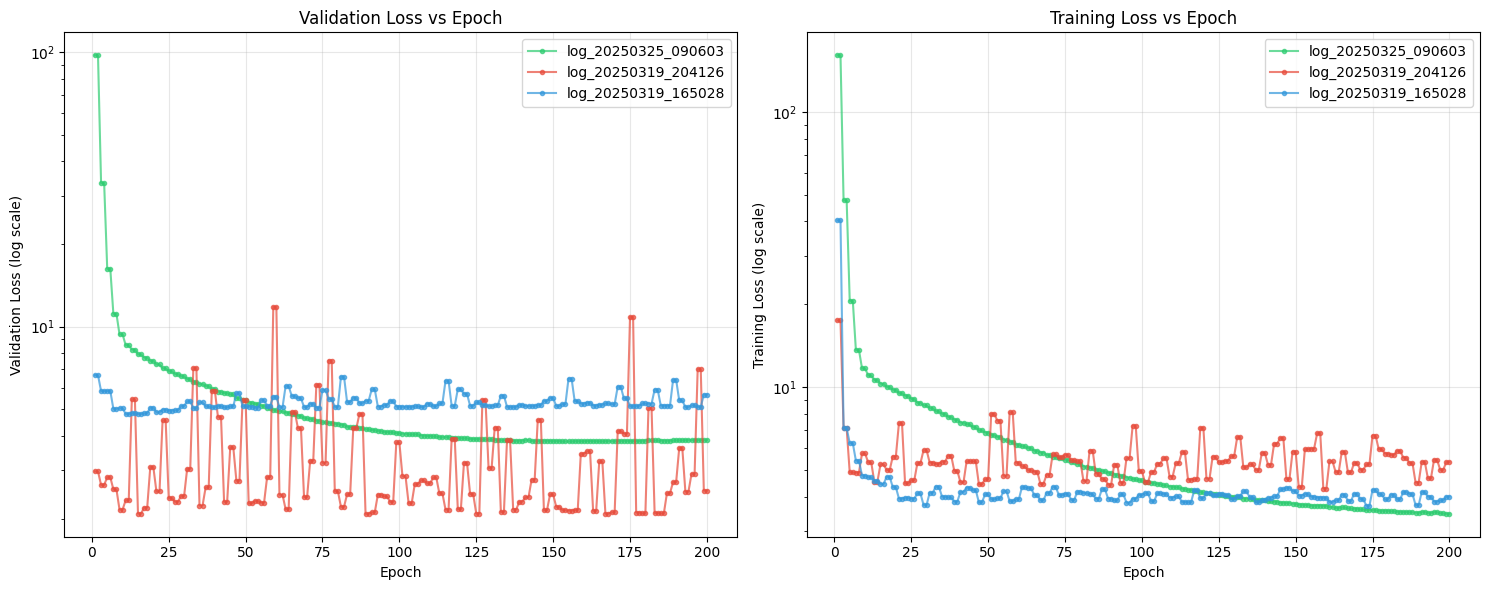

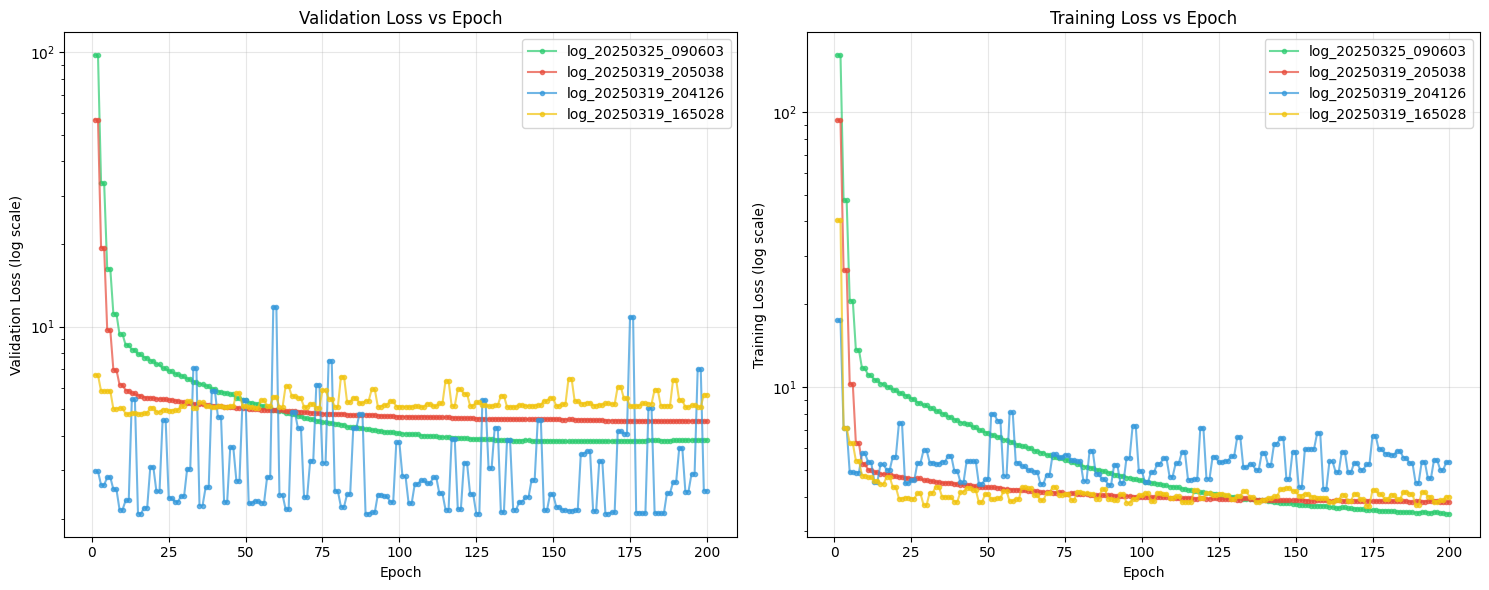

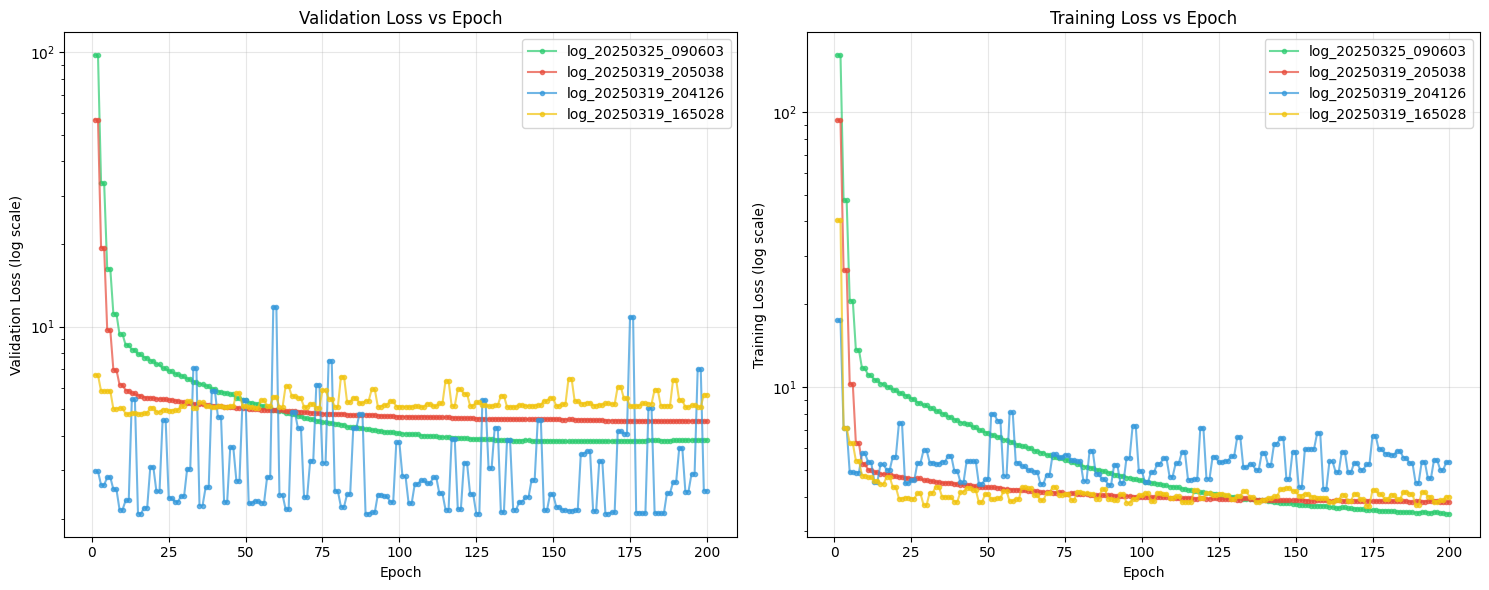

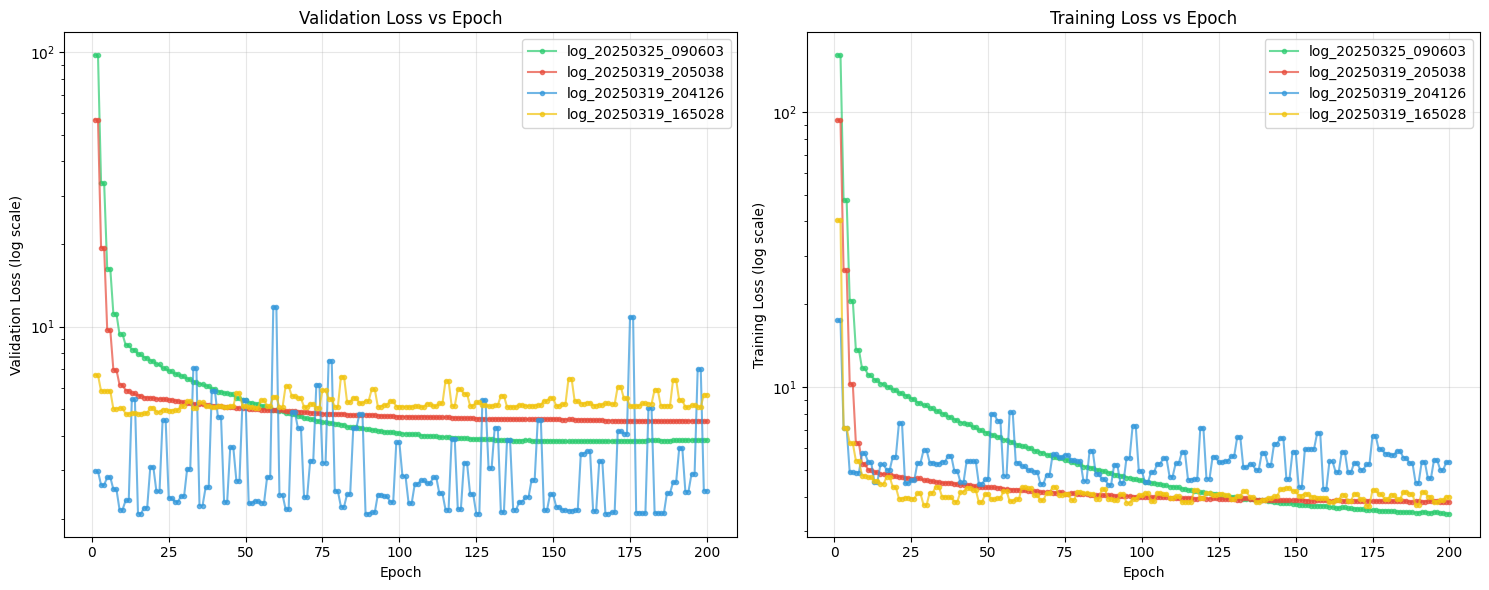

In [2]:
# Second chunk - creates interactive visualizations
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact

def extract_loss_history(filename):
    with open(filename, 'r') as f:
        content = f.read()
    
    # Extract learning rate for labeling
    learning_rate = float(re.search(r'LEARNING_RATE: ([\d\.]+)', content).group(1))
    
    # Extract training and validation losses per epoch
    train_losses = []
    val_losses = []
    
    # Find all epoch blocks
    epoch_blocks = re.finditer(r'Epoch \d+/\d+: 100%.*?train_loss=([\d\.]+), val_loss=([\d\.]+)', content)
    
    for match in epoch_blocks:
        train_loss = float(match.group(1))
        val_loss = float(match.group(2))
        train_losses.append(train_loss)
        val_losses.append(val_loss)
    
    # Create epoch numbers
    epochs = np.arange(1, len(train_losses) + 1)
    
    return learning_rate, epochs, train_losses, val_losses

# Function to update plots based on checkbox selection
def update_plots(*args):
    # Set style parameters - use a standard matplotlib style instead of seaborn
    # plt.style.use('seaborn')  # This was causing the error
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f1c40f', '#9b59b6', '#1abc9c', '#d35400', '#34495e']
    
    # Get selected experiments based on checkboxes
    selected_indices = [idx for idx in checkboxes if checkboxes[idx].value]
    selected_experiments = df.loc[selected_indices]
    
    if len(selected_experiments) == 0:
        print("Please select at least one experiment to visualize.")
        return
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    # First subplot for validation loss
    for i, (_, row) in enumerate(selected_experiments.iterrows()):
        full_path = os.path.join(log_dir, row['Filename'])
        try:
            lr, epochs, train_losses, val_losses = extract_loss_history(full_path)
            # Extract filename without training_ prefix and .txt extension
            filename = row['Filename'].replace('training_', '').replace('.txt', '')
            ax1.plot(epochs, val_losses, label=filename, color=colors[i % len(colors)],
                     marker='o', markersize=3, alpha=0.7)
        except Exception as e:
            print(f"Error processing {row['Filename']}: {str(e)}")
    
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Validation Loss (log scale)')
    ax1.set_title('Validation Loss vs Epoch')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    # Second subplot for training loss
    for i, (_, row) in enumerate(selected_experiments.iterrows()):
        full_path = os.path.join(log_dir, row['Filename'])
        try:
            lr, epochs, train_losses, val_losses = extract_loss_history(full_path)
            # Extract filename without training_ prefix and .txt extension
            filename = row['Filename'].replace('training_', '').replace('.txt', '')
            ax2.plot(epochs, train_losses, label=filename, color=colors[i % len(colors)],
                     marker='o', markersize=3, alpha=0.7)
        except Exception as e:
            print(f"Error processing {row['Filename']}: {str(e)}")
    
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Training Loss (log scale)')
    ax2.set_title('Training Loss vs Epoch')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Create a button to update the plots
update_button = widgets.Button(description="Update Plots")
update_button.on_click(update_plots)
display(update_button)

# Initial plot with all experiments selected
update_plots()